In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import torch

%matplotlib inline

In [97]:
file_template = 'reconstruction/{0}/reconstruction_data.pth'

model_folder_names = [ 'size-64-64_gan-adam_10000_500',
                       'size-64-64_wgan-rmsprop_10000_500',
                       'size-64-64_wgangp-adam_10000_500'
                     ]

model_legend_names = ['GAN',
                      'WGAN',
                      'Improved WGAN'
                     ]
class_names = ['neutrophils']

## FUNCS

In [98]:
def mad(arr):
    med = np.median(arr)
    return np.median(np.abs(arr - med))

def print_info(model, lls, dists):
    lls = np.array(lls)
    dists = np.array(dists)

    '''
    print('NLL={0:0.0f}\u00B1{1:0.0f}; L2={2:0.3f}\u00B1{3:0.3f} - {4}'.format(np.median(lls), mad(lls),
                                                                               np.median(dists), mad(dists),
                                                                               model))
    '''
    print('NLL={0:0.0f}\u00B1{1:0.0f}; L2={2:0.3f}\u00B1{3:0.3f} - {4}'.format(np.mean(lls), np.std(lls),
                                                                               np.mean(dists), np.std(dists),
                                                                               model))
    
def print_stats(file_template, model_folder_names, class_names, model_legend_names=None):
    if model_legend_names is None:
        model_legend_names = model_folder_names
    lls_all = {m: [] for m in model_folder_names}
    dists_all = {m: [] for m in model_folder_names}
    for cl in class_names:
        print('Class', cl)
        for i_model, model in enumerate(model_folder_names):
            data = torch.load(file_template.format(model))
            lls = data['lls_noise'][cl]
            dists = data['l2_dists'][cl]
            print_info(model_legend_names[i_model], lls, dists)
            lls_all[model] += lls
            dists_all[model] += dists

    
    #for i_model, model in enumerate(model_folder_names):
    #    print_info(model_legend_names[i_model], lls_all[model], dists_all[model])       
        
def do_scatter_plots(file_template, model_folder_names, class_names, model_legend_names=None,
                     nn_data=None, nll_mean=None, nll_std=None, save_prefix=None):
    if model_legend_names is None:
        model_legend_names = model_folder_names
    lls = []
    dists = []
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    for cl in class_names:
        fig = plt.figure(figsize=(5,4))
        ax = fig.add_subplot(111)

        for i_model, model in enumerate(model_folder_names):
            data = torch.load(file_template.format(model))
            lls = data['lls_noise'][cl]
            dists = data['l2_dists'][cl]
            ax.scatter(dists, lls)

        ax.legend(model_legend_names)
        ax.set_xlabel(r'$L_2$-error')
        ax.set_ylabel(r'NLL')
        # ax.set_title(cl)

        if nn_data is not None:
            ax.plot([nn_data[cl][0], nn_data[cl][0]], [0, 1000], "-", color='blue', zorder=-100)
            ax.plot([nn_data[cl][0] + nn_data[cl][1] * 3, nn_data[cl][0] + nn_data[cl][1] * 3], [0, 1000], "--", color='gray')
            ax.plot([nn_data[cl][0] - nn_data[cl][1] * 3, nn_data[cl][0] - nn_data[cl][1] * 3], [0, 1000], "--", color='gray')
        
        if nll_mean is not None:
            ax.plot([0, 1], [nll_mean, nll_mean], "-", color='gray', zorder=-100)
            if nll_std is not None:
                ax.plot([0, 1], [nll_mean + 3 * nll_std, nll_mean + 3 * nll_std], "--", color='gray', zorder=-100)
                ax.plot([0, 1], [nll_mean - 3 * nll_std, nll_mean - 3 * nll_std], "--", color='gray', zorder=-100)
                
        #ax.axis((0.02, 0.14, 100, 300))
        if save_prefix is not None:
            fig.savefig(save_prefix + '_' + cl + '.pdf', bbox_inches='tight')
        plt.show()
        

## FUNCS

In [61]:

def print_nn_info(dists):
    dists = np.array(dists)
    dists_avg = np.mean(dists)
    dists_std = np.std(dists)
    
    print('L2={0:0.3f}\u00B1{1:0.3f}'.format(dists_avg, dists_std))
    
    
    dists_median = np.median(np.array(dists))
    dists_mad = mad(np.array(dists))
    print('L2={0:0.3f}\u00B1{1:0.3f}'.format(dists_median, dists_mad))
    
    return dists_avg, dists_std

def print_nn_dists(data, class_names):
    nn_data = {}
    dists_all = []
    for cl in class_names:
        dists = data['l2_dists'][cl]
        dists_median, dists_mad = print_nn_info(dists)
        dists_all += dists
        nn_data[cl] = (dists_median, dists_mad)

    nn_data['all'] = (dists_median, dists_mad)
    return nn_data
 
# get the nearest neighbor distance0
data0 = torch.load(file_template.format(model_folder_names[0]))
nn_data0 = print_nn_dists(data0, class_names)
print (nn_data0)

L2=0.044±0.006
L2=0.043±0.004
{'neutrophils': (0.043699578557565323, 0.0062729207628393598), 'all': (0.043699578557565323, 0.0062729207628393598)}


# PLOT

In [99]:
# compute the mean and std of distance to the origin of the Gaussian samples
np.random.seed(42)
noise_dim = 100
mvn = multivariate_normal(np.zeros(noise_dim), np.identity(noise_dim))
points = mvn.rvs(size=100)
nlls = -mvn.logpdf(points)
nll_mean, nll_std = np.mean(nlls), np.std(nlls)
#plt.hist(nlls, bins=100)
print('Mean: {0:0.0f}; std: {1:0.0f}'.format(nll_mean, nll_std))

Mean: 142; std: 7


In [100]:
print_stats(file_template, model_folder_names, class_names, model_legend_names=model_legend_names)

Class neutrophils
NLL=146±12; L2=0.142±0.025 - GAN
NLL=172±9; L2=0.073±0.013 - WGAN
NLL=170±14; L2=0.041±0.006 - Improved WGAN


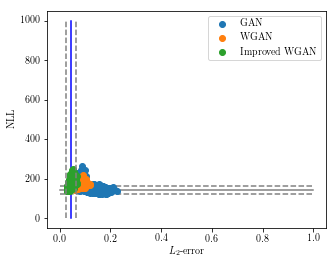

In [101]:
do_scatter_plots(file_template, model_folder_names, class_names, model_legend_names,
                 nn_data0, nll_mean, nll_std, save_prefix=None)

In [ ]:
do_scatter_plots(file_template, model_folder_names, class_names, model_legend_names,
                 nn_data0, nll_mean, nll_std, save_prefix='reconstruction-regular-5000')

### 5000

In [ ]:
file_template = 'reconstruction/{0}/reconstruction_data.pth'

model_folder_names = [ 'size-64-64_gan-adam_10000',
                       'size-64-64_wgan-rmsprop_10000',
                       'size-64-64_wgangp-adam-10000'
                     ]

model_legend_names = [  'GAN',
                        'WGAN',
                        'Improved WGAN'
                     ]
class_names = ['neutrophils']

In [ ]:
# get the nearest neighbor distance0
data0 = torch.load(file_template.format(model_folder_names[0]))
nn_data0 = print_nn_dists(data0, class_names)
print (nn_data0)

In [ ]:
print_stats(file_template, model_folder_names, class_names, model_legend_names=model_legend_names)

In [ ]:
do_scatter_plots(file_template, model_folder_names, class_names, model_legend_names,
                 nn_data0, nll_mean, nll_std, save_prefix='reconstruction-regular-10000')